# Exploratory Data Analysis (EDA) - Online Retail Dataset

**About the dataset:**

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Feature Information:**

| Name | Description |
| :-- | :-- |
| InvoiceNo | Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. |
| StockCode | Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. |
| Description | Product (item) name. Nominal. |
| Quantity | The quantities of each product (item) per transaction. Numeric. |
| InvoiceDate | Invice Date and time. Numeric, the day and time when each transaction was generated. |
| UnitPrice | Unit price. Numeric, Product price per unit in sterling. |
| CustomerID | Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. |
| Country | Country name. Nominal, the name of the country where each customer resides. |

The dataset can be downloaded from below link:

https://archive.ics.uci.edu/ml/datasets/Online+Retail

In [1]:
# Import required libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Load the data
data_path = 'Online_Retail.xlsx'

data = pd.read_excel(data_path)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Data Wrangling

### 1. Check for null values in data

In [5]:
null_df = (
    (data.isnull().sum()/data.shape[0]*100)
    .to_frame()
    .reset_index()
    .rename(columns={'index':'Column', 0:'Null%'})
)

null_df

,Column,Null%
0,InvoiceNo,0.000000
1,StockCode,0.000000
2,Description,0.268311
3,Quantity,0.000000
4,InvoiceDate,0.000000
5,UnitPrice,0.000000
6,CustomerID,24.926694
7,Country,0.000000


- **Description** and **CustomerID** are the only columns with null values
- **CustomerID** has a high percentage of null values

Since both **StockCode** and **Description** provide information about a product, we can use StockCode to fill the null values in Description.

But before that we need to check if StockCode's whose Description is Nan have any other non-null entries in Description column

In [6]:
# List StockCode's with Nan Description
product_code_list1 = data.loc[data['Description'].isna(), 'StockCode'].unique()
print(f"No. of StockCode's having Nan entries in Description: {len(product_code_list1)}")

No. of StockCode's having Nan entries in Description: 960


In [7]:
# Check if any of the StockCode's listed in previous cell have Description other than Nan
product_code_list2 = data.loc[(~data['Description'].isna()) & (data['StockCode'].isin(product_code_list1)), 'StockCode'].unique()

In [8]:
if len(product_code_list2) > 0:
    print(f"{len(product_code_list2)} StockCode's have other non-null entries in Description column")
else:
    pass

848 StockCode's have other non-null entries in Description column


In [9]:
# Create a dictionary of item code and item description
item_dict = data[data['StockCode'].isin(product_code_list2)].groupby(['StockCode'])['Description'].agg(pd.Series.mode).to_dict()

In [10]:
# Fill the null values from Description column using the item dictionary
data['Description'] = data['Description'].fillna(data['StockCode'].map(item_dict))

In [11]:
null_df = (
    (data.isnull().sum()/data.shape[0]*100)
    .to_frame()
    .reset_index()
    .rename(columns={'index':'Column', 0:'Null%'})
)

null_df

,Column,Null%
0,InvoiceNo,0.000000
1,StockCode,0.000000
2,Description,0.020668
3,Quantity,0.000000
4,InvoiceDate,0.000000
5,UnitPrice,0.000000
6,CustomerID,24.926694
7,Country,0.000000


- Null % in Description columns has been reduced from 0.26 to 0.02
- Leave the CustomerID as it is

## Exploratory Data Analysis

In [12]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


From the above data description of the numerical columns it can be seen that there are negative values in **Quantity** and **UnitPrice**

**Assumption:** Quantities, with their corresponding UnitPrice values, having negative values were returned or cancelled.

To verify the assumption lets look at the **InvoiceNo** of the Quantities with negative value and see the InvoiceNo starts with a **C** which stands for cancelled.

In [13]:
# List of Invoice No. where Quantity < 0
invoice_list = data[data['Quantity']<0]['InvoiceNo'].unique().tolist()
print(f"There are a total of {len(invoice_list)} Invoice No.'s with Quantity less than 0")

There are a total of 5172 Invoice No.'s with Quantity less than 0


In [14]:
# Check the number of cancelled InvoiceNo's from above InvoiceNo list
invoice_list_cancelled = [invoice for invoice in invoice_list if 'c' in str(invoice).lower()]
print(f"Percentage of Cancelled InvoiceNo from list of Invoice's with negative Quantity: {len(invoice_list_cancelled)/len(invoice_list)*100}")

Percentage of Cancelled InvoiceNo from list of Invoice's with negative Quantity: 74.16860015467904


Hence its safe to assume that Quantities having negative values were returned or cancelled.

### Percentage of Cancelled Orders

In [15]:
cancelled_orders = data[data['InvoiceNo'].astype(str).str.contains('C')]['InvoiceNo'].nunique()
total_orders = data['InvoiceNo'].nunique()
print(f"Total orders: {total_orders}")
print(f"No. of cancelled orders: {cancelled_orders}")
print(f"Percentage of cancelled orders: {cancelled_orders}/{total_orders} = {round(cancelled_orders/total_orders*100, 2)}%")

Total orders: 25900
No. of cancelled orders: 3836
Percentage of cancelled orders: 3836/25900 = 14.81%


### Average number of orders per customer

In [16]:
group_data = (data.groupby('CustomerID')['InvoiceNo']
              .nunique().to_frame()
              .rename(columns={'InvoiceNo':'No_of_Orders'})
             )
group_data.head()

,No_of_Orders
CustomerID,
12346.0,2
12347.0,7
12348.0,4
12349.0,1
12350.0,1


In [17]:
group_data.describe()

,No_of_Orders
count,4372.000000
mean,5.075480
std,9.338754
min,1.000000
25%,1.000000
50%,3.000000
75%,5.000000
max,248.000000


In [18]:
print(f"Average number of orders per customer: {round(group_data.mean()['No_of_Orders'])}")

Average number of orders per customer: 5


### Average number of unique items per order

In [19]:
group_data = (data.groupby('InvoiceNo')['StockCode']
              .nunique().to_frame()
              .rename(columns={'StockCode':'Uniq_Items'})
             )
group_data.head()

,Uniq_Items
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [20]:
group_data.describe()

,Uniq_Items
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


In [21]:
print(f"Average number of unique items per order: {round(group_data.mean()['Uniq_Items'])}")

Average number of unique items per order: 21


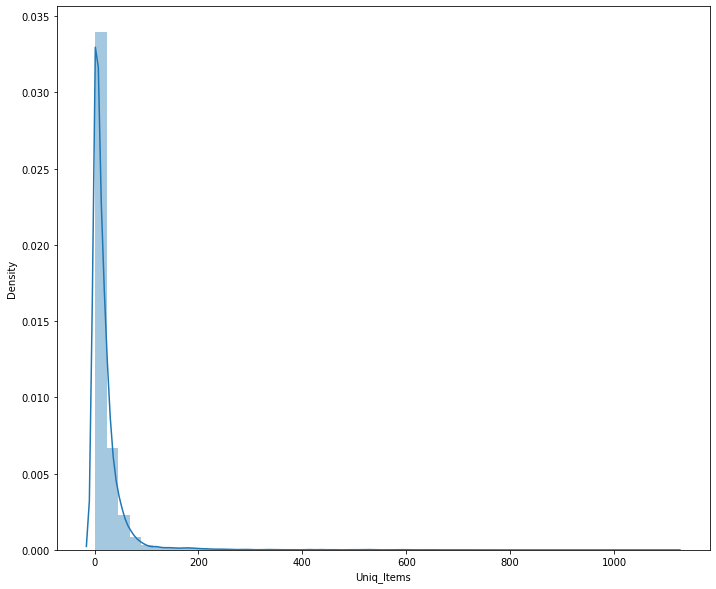

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.distplot(group_data['Uniq_Items'],ax=ax)
plt.show()

- **Its clearly visible that the number of unique items per order is Right Skewed**
- **It can be inferred that people tend to buy less than 20 items per order**

### Top 10 countries w.r.t Revenue

In [23]:
data['total_cost'] = data['Quantity'] * data['UnitPrice']

In [24]:
group_data = (data.groupby('Country')['total_cost']
              .sum()
              .reset_index()
              .sort_values('total_cost', ascending=False)
              .rename(columns={'total_cost':'Revenue'})
             )
group_data = group_data.iloc[:10,:]

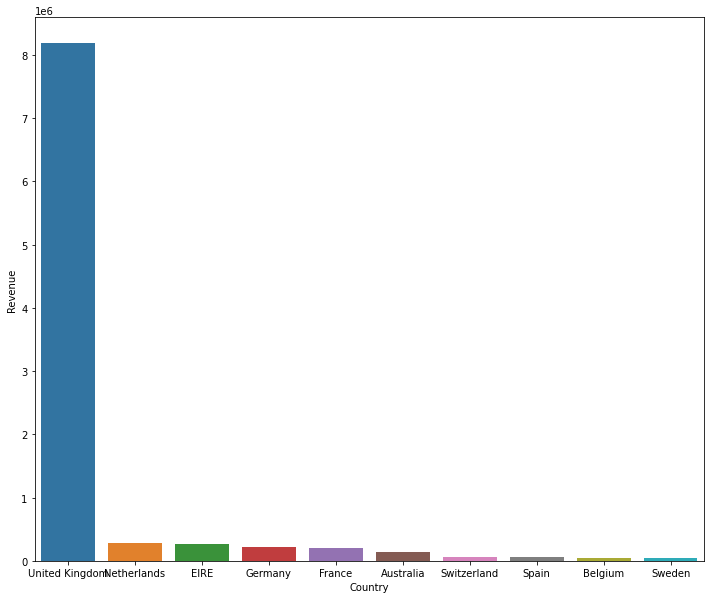

In [25]:
plt.figure(figsize=(12,10))
sns.barplot(x='Country', y='Revenue', data=group_data)
plt.show()

### Top 10 countries w.r.t Customers

In [26]:
group_data = (data.groupby('Country')['CustomerID']
              .nunique()
              .reset_index()
              .sort_values('CustomerID', ascending=False)
              .rename(columns={'CustomerID':'No. of Customers'})
             )
group_data = group_data.iloc[:10,:]

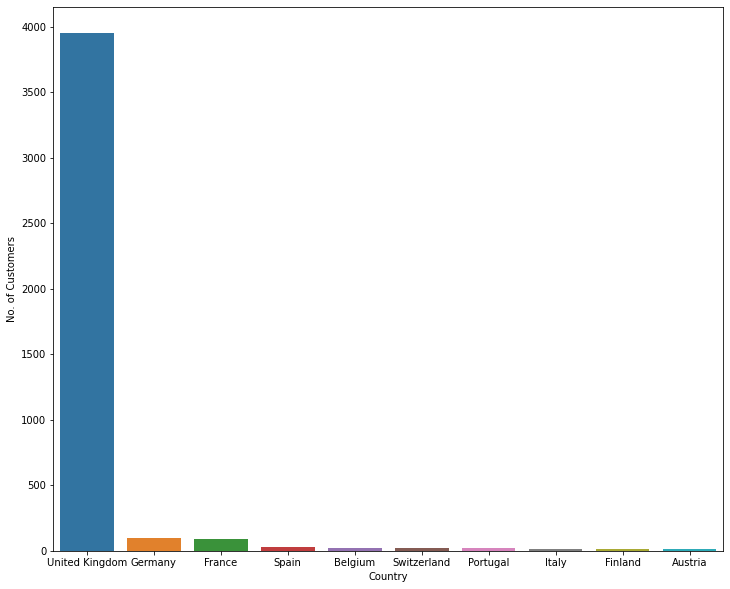

In [27]:
plt.figure(figsize=(12,10))
sns.barplot(x='Country', y='No. of Customers', data=group_data, )
plt.show()

The above plots show that UK has a monopoly in terms of both revenue and number of customers.

**Hence it can be concluded that UK has the biggest market.**

## Explore data from UK

In [28]:
data_uk = data[data['Country']=='United Kingdom']

### Some important Stat's

In [29]:
print("Total number of transactions: ", data_uk['InvoiceNo'].nunique())
print("Total number of unique products bought: ",data_uk['StockCode'].nunique())
print("Total number of unique customers:", data_uk['CustomerID'].nunique() )

Total number of transactions:  23494
Total number of unique products bought:  4065
Total number of unique customers: 3950


### Products that are most bought in UK

In [30]:
group_data = (data_uk.groupby('StockCode', as_index=False)['Quantity']
              .sum()
              .sort_values('Quantity', ascending=False)
             )
group_data.head(10)

,StockCode,Quantity
1068,22197,52928
2620,84077,48326
3655,85099B,43167
3666,85123A,36706
2733,84879,33519
1451,22616,25307
375,21212,24702
1049,22178,23242
39,17003,22801
887,21977,20288
